### Import section

In [2]:
import pandas as pd
import numpy as np
import requests
import urllib
import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime

### Reading files

In [3]:
# Create a function for reading files from Yandex Disk.
def link_reader(folder_path, file_path):
    """
    Reads a CSV file from a specified location on Yandex Disk and returns its content as a pandas DataFrame.

    This function constructs a download URL for the specified file located in a Yandex Disk public folder. It then attempts to download the file and load its contents into a pandas DataFrame, assuming the file is in CSV format.

    Parameters:
    - folder_path (str): The public key or URL of the Yandex Disk folder containing the file.
    - file_path (str): The path to the file within the Yandex Disk folder.

    Returns:
    - pandas.DataFrame: The contents of the CSV file as a DataFrame. Returns None if an error occurs during file download or reading.

    Raises:
    - Exception: Describes the error that occurred during the reading of the CSV file if the operation fails.
    """
    folder_url = folder_path
    file_url = file_path
    url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download' + '?public_key=' + urllib.parse.quote(folder_url) + '&path=/' + urllib.parse.quote(file_url)
    r = requests.get(url)  # request for the download link
    h = json.loads(r.text)['href']  # parsing the download link
    try:
        df = pd.read_csv(h, sep=',', comment='#', encoding='cp1251')
    except Exception as e:
        print(f"An error occurred while reading the CSV file: {e}")
        df = None
    return df


In [4]:
# Reading files using the previously created function and write df to variables.

customers = link_reader('https://disk.yandex.ru/d/BcXB_CuKVX1LRw', 'olist_customers_dataset.csv')
items = link_reader('https://disk.yandex.ru/d/BcXB_CuKVX1LRw', 'olist_order_items_dataset.csv')
orders = link_reader('https://disk.yandex.ru/d/BcXB_CuKVX1LRw', 'olist_orders_dataset.csv')

In [5]:
print(customers.shape)
print(orders.shape)
print(items.shape)


(99441, 5)
(99441, 8)
(112650, 7)


In [6]:
print(customers.customer_id.nunique())
print(orders.order_id.nunique())
print(customers.customer_unique_id.nunique())

99441
99441
96096


### 1. How many users do we have who made a purchase only once?

First and foremost, it is necessary to define what constitutes a purchase in the data and who is considered a unique user in our data.

After conducting a preliminary investigation of the data, it became clear that since the "customer_id" column contains data about a user linked to a specific order, the only way to identify unique users is through the "customer_unique_id" column in the "customers" table.

The task was set to find those customer_unique_ids for which the number of purchases does not exceed 1. In this case, each order is identified by the "order_id" column.

It is also worth noting that an order != a purchase. I define a purchase as an order that has one of the following statuses: 'approved', 'invoiced', 'processing', 'shipped', 'delivered', and also has a non-empty "order_approved_at" value, i.e., the order payment confirmation time.

The status 'invoiced' deserves a separate interpretation. By definition, this status does not constitute a purchase but is merely the issuance of an invoice. Nevertheless, among the data with this status, there are details about the payment confirmation time. Accordingly, I assume that the user made a purchase where the payment time is recorded, but the status has not yet changed. This could happen in situations where the change of order status is not automated, i.e., a person must directly change the order status, while data about the payment confirmation time are uploaded automatically.

It is also important to note that using the "order_approved_at" column as the sole filter confirming a purchase is not possible, as data on the confirmation time can remain even if the order is canceled and a refund is issued to the user, which in turn cannot be called a purchase.

The order status "created" does not correspond to a purchase, as the fact of payment is still absent.
The order status "canceled" will be interpreted as an order cancellation by the customer/user.
The order status "unavailable" will be interpreted as an inability to fulfill the order, possibly due to the seller not having the goods in stock.

In [7]:
# To solve this task, I joined the "customer_unique_id" column from the df "customers" to the df "orders"
orders = pd.merge(orders, customers[["customer_id", "customer_unique_id"]], on="customer_id", how='left')

# In this block of code, I rearranged the "customer_unique_id" column to the front for convenience
columns = list(orders.columns)
new_order = columns[-1:] + columns[:-1]
orders = orders[new_order]

# In this block, I converted all date columns to datetime format
date_col = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
orders[date_col] = orders[date_col].apply(pd.to_datetime)
orders

,customer_unique_id,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,72632f0f9dd73dfee390c9b22eb56dd6,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26
...,...,...,...,...,...,...,...,...,...
99436,6359f309b166b0196dbf7ad2ac62bb5a,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28
99437,da62f9e57a76d978d02ab5362c509660,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02
99438,737520a9aad80b3fbbdad19b66b37b30,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27
99439,5097a5312c8b157bb7be58ae360ef43c,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15


In [8]:
# In this block of code, we will filter the data to count the number of customers who have made no more than one purchase.
# First, we'll filter orders by the statuses that meet our criteria. Then, we'll group by each user and count the number of purchases for each.
# After that, we'll keep only those who have made a purchase no more than once. The result is stored in "single_purchases"
# Thus, the number of users who made a purchase no more than once = 92087

approved_statuses = ['approved', 'invoiced', 'processing', 'shipped', 'delivered']
single_purchases = orders.query('order_status in @approved_statuses and order_approved_at.notna()') \
    .groupby('customer_unique_id') \
    .agg({"order_id" : 'count'})
single_purchases = single_purchases.query('order_id < 2').shape[0]
print(f'The number of users who made a purchase no more than once = {single_purchases}')


The number of users who made a purchase no more than once = 92087


#### Answer:
Number of users who made a purchase no more than once = 92087

### 2. How many orders per month on average are not delivered for various reasons (provide details by reason)?

To solve this task, let's first determine that an order is considered undelivered if it has the status "canceled" or "unavailable". We need to find the average monthly values for orders that meet such statuses.

In [9]:
# First, let's create a column with months for all orders. The column is created based on the expected delivery date parameter
orders['month'] = orders.order_estimated_delivery_date.dt.to_period('M').dt.to_timestamp()

In [10]:
# Next, filter the data by status "canceled" or "unavailable",
# then group the data by status and the month the order was supposed to be delivered,
# count the number of such orders, and format the resulting dataframe into a more convenient form using the pivot method
# Finally, calculate the average values per month for each of the statuses.
# As a result, due to order cancellation, an average of 24 orders per month are not delivered, and due to order unavailability, 29 orders

undelivered = orders.query('order_status == "canceled" or order_status == "unavailable"') \
.groupby(['month', 'order_status'], as_index=False) \
.order_id.count() \
.pivot(columns='order_status', index='month', values='order_id')
undelivered_canceled_mean = round(undelivered.canceled.mean())
undelivered_unavailable_mean = round(undelivered.unavailable.mean())

print(f'On average per month, {undelivered_canceled_mean} orders are not delivered due to cancellation')
print(f'On average per month, {undelivered_unavailable_mean} orders are not delivered due to unavailability')


On average per month, 24 orders are not delivered due to cancellation
On average per month, 29 orders are not delivered due to unavailability


<Axes: title={'center': 'Undelivered orders monthly'}, xlabel='Month', ylabel='Undelivered orders'>

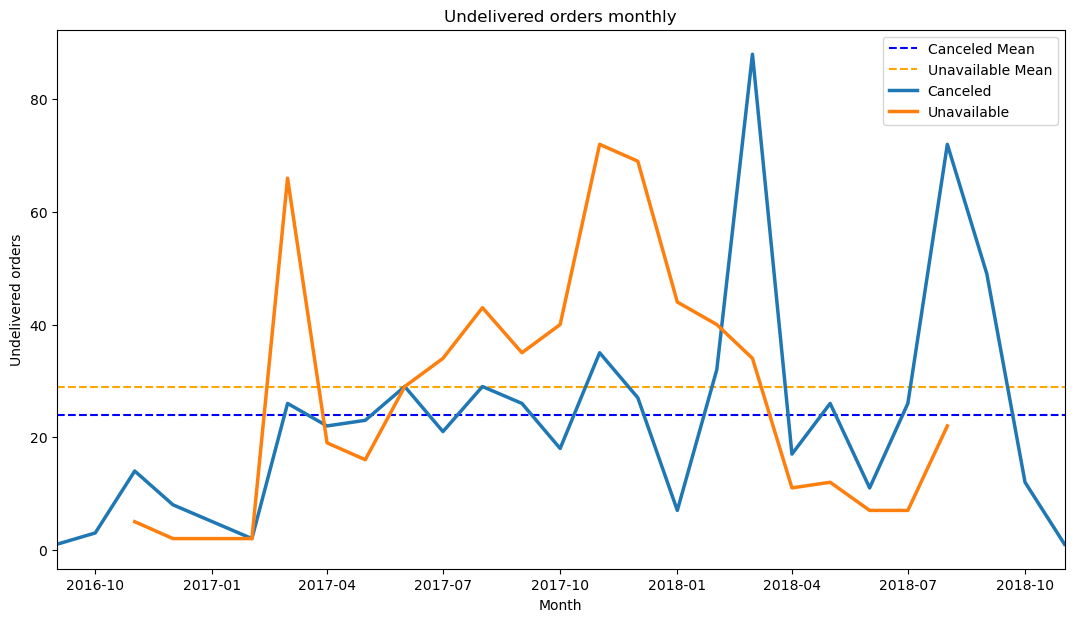

In [11]:
# Visualization of undelivered orders by reason

month_lst = undelivered.reset_index().month.to_list()
plt.figure(figsize=(13, 7))
plt.title('Undelivered orders monthly')
plt.xlabel('Month')
plt.ylabel('Undelivered orders')
plt.axhline(y=undelivered_canceled_mean, color='blue', linestyle='--', label='Canceled Mean')
plt.axhline(y=undelivered_unavailable_mean, color='orange', linestyle='--', label='Unavailable Mean')
plt.xlim(min(month_lst), max(month_lst))
sns.lineplot(data=undelivered, x='month', y='canceled', label='Canceled', linewidth=2.5)
sns.lineplot(data=undelivered, x='month', y='unavailable', label='Unavailable', linewidth=2.5)


#### Answer:
On average per month, 24 orders are not delivered due to cancellation  
On average per month, 29 orders are not delivered due to unavailability

### 3. For each product, determine on which day of the week it is most often purchased.
In this task, it is necessary to find the day of the week on which the purchase of each product most often occurs. Previously, we defined the criteria for a purchase as the presence of a payment fact, as well as a number of statuses. Nonetheless, in this task, I will define a purchase as the moment when a user creates an order or, to rephrase, the moment when a user decides to make a purchase. I do not find it difficult to perform similar calculations for the moment of payment for specific goods, but in my opinion, for business, information about the moment when a user decides is more important than confirming their decision with a payment.

To solve the task, we will create a dataframe based on the orders table, to which we will add a column with the order creation time. We will also create a column with the corresponding days of the week from the order creation time column. After that, we will group by the days of the week and product, and count the number of occurrences. The obtained result will be filtered using loc. Where for each product, we will find the day of the week on which the most purchases were made. The obtained result will be recorded in the df "purchase_dow"

In [12]:
items_ordering = pd.merge(items, orders[["order_id", "order_purchase_timestamp"]], on="order_id", how="left")
days_of_week = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
items_ordering['day_of_week'] = items_ordering['order_purchase_timestamp'].dt.dayofweek.map(days_of_week)
days = items_ordering.groupby(['product_id', 'day_of_week'], as_index=False).agg({'order_id' : 'count'})
purchase_dow = days.loc[days.groupby('product_id')['order_id'].idxmax()].rename(columns={'order_id' : 'orders_quantity'})

#### Answer:
Dataframe ***purchase_dow***

In [13]:
purchase_dow.sort_values(by='orders_quantity')  # Thus, we obtain a dataframe in which for each order 
# the day of the week with the highest number of orders is determined, as well as the quantity of orders for this product on that day


,product_id,day_of_week,orders_quantity
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
37470,9d489ab920498d03a7eb2c70866e5982,Monday,1
37469,9d47dddcc5eb825534e212b1b927385f,Monday,1
37467,9d40080a29872ddbfe64f036de4ccdd1,Thursday,1
37465,9d3df566a74fbf502fb8badaa5044e74,Friday,1
...,...,...,...
13537,389d119b48cf3043d311335e499d9c6b,Thursday,67
20127,53b36df67ebb7c41585e8d54d6772e08,Tuesday,76
41045,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
36513,99a4788cb24856965c36a24e339b6058,Monday,92


/Users/davidgrigorev/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Monday'),
  Text(1, 0, 'Tuesday'),
  Text(2, 0, 'Wednesday'),
  Text(3, 0, 'Thursday'),
  Text(4, 0, 'Friday'),
  Text(5, 0, 'Saturday'),
  Text(6, 0, 'Sunday')])

<Figure size 1300x700 with 0 Axes>

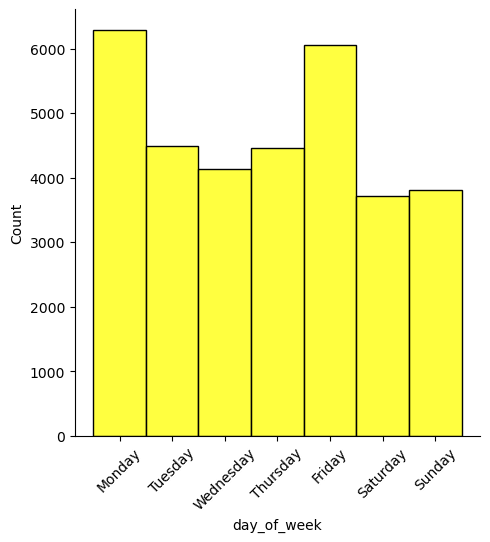

In [14]:
# Visualize the distribution of all products ordered for each day of the week

# Preparation for the plot. We determine the order of displaying days of the week on the graph. By default, Monday would be last
desired_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
purchase_dow['day_of_week'] = pd.Categorical(purchase_dow['day_of_week'], categories=desired_order, ordered=True)
purchase_dow = purchase_dow.sort_values('day_of_week')

# Constructing the distribution
plt.figure(figsize=(13, 7))
sns.displot(data=purchase_dow, x='day_of_week', bins=7, color='yellow')
plt.xticks(rotation=45)


### 4. Using pandas, conduct a cohort analysis of users. In the period from January to December, identify the cohort with the highest retention in the 3rd month.

First of all, we will determine that we will calculate the retention rate using the order_purchase_timestamp column.
Here you will also need to isolate the month from the date, and also find the month of the first purchase for each user. Then we will create a pivot table with cohorts. It is also worth noting that the purchase criteria are important for the retention rate. That is, in this case, we define a completed action as a purchase, and a purchase is defined as an order that has one of these statuses: 'approved', 'invoiced', 'processing', 'shipped', 'delivered', and also has a time confirmation of payment for the order i.e. "order_approved_at" is not empty


In [15]:
print(orders.order_purchase_timestamp.min())
print(orders.order_purchase_timestamp.max())

2016-09-04 21:15:19
2018-10-17 17:30:18


In [16]:
approved_statuses = ['approved', 'invoiced', 'processing', 'shipped', 'delivered']
purchases = orders.query('order_status in @approved_statuses and order_approved_at.notna()')

Since we have data for the period 2016-09-04 - 2018-10-17, and we need to look at data for the year from January to December, it would be logical to look at data for 2017. Thus, we will have 12 cohorts for each month of 2017.

First of all, let's create a df from the customer_unique_id and order_purchase_timestamp columns. It is these two columns that will become the basis for the cohort table.

Also, based on the order_purchase_timestamp column, we need to find the first month of the order for each client; this data will be our cohorts. We will also convert all dates into a more convenient format.

In [17]:
# Create a new dataframe
cohort_df = purchases[['customer_unique_id', 'order_purchase_timestamp']]

# Add a column for the month of the first purchase for each user
cohort_df['order_month'] = cohort_df['order_purchase_timestamp'].dt.to_period('M')
cohort_df['first_purchase'] = cohort_df.groupby('customer_unique_id') \
    ['order_purchase_timestamp'].transform('min').dt.to_period('M')

# Filter the dataframe by the required dates
cohort_df = cohort_df[['customer_unique_id', 'order_month', 'first_purchase']] \
    .query('first_purchase >= "2017-01" and first_purchase <= "2017-12"')
cohort_df


/var/folders/0n/jvmrq9551fv53nwvmxvjp96c0000gn/T/ipykernel_23388/1911604233.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cohort_df['order_month'] = cohort_df['order_purchase_timestamp'].dt.to_period('M')
/var/folders/0n/jvmrq9551fv53nwvmxvjp96c0000gn/T/ipykernel_23388/1911604233.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cohort_df['first_purchase'] = cohort_df.groupby('customer_unique_id') \


,customer_unique_id,order_month,first_purchase
0,7c396fd4830fd04220f754e42b4e5bff,2017-10,2017-09
3,7c142cf63193a1473d2e66489a9ae977,2017-11,2017-11
5,80bb27c7c16e8f973207a5086ab329e2,2017-07,2017-07
6,36edbb3fb164b1f16485364b6fb04c73,2017-04,2017-04
7,932afa1e708222e5821dac9cd5db4cae,2017-05,2017-05
...,...,...,...
99433,c716cf2b5b86fb24257cffe9e7969df8,2017-10,2017-10
99434,e03dbdf5e56c96b106d8115ac336f47f,2017-01,2017-01
99435,831ce3f1bacbd424fc4e38fbd4d66d29,2017-02,2017-02
99436,6359f309b166b0196dbf7ad2ac62bb5a,2017-03,2017-03


Next, it is necessary to create what is known as cohort dimensions, i.e., periods during which each cohort will be evaluated. To do this, we will create a `cohort_idx` column that will contain data on the number of months that have passed from the moment of the initial purchase to the moment of the current order being considered in our data.

After that, we can group the data by `first_purchase` and `cohort_idx` and count the number of unique `customer_unique_id`s. This way, we will obtain data for each cohort with the number of clients in each subsequent month. It should also be noted that we count unique users because a user can potentially make several purchases in one month, but for us, this data will be redundant since we calculate the retention rate not by days but by months.

Next, we will make a pivot table from the aggregated data.

In [18]:
# Creating dimensions for our cohorts based on the difference between the current date value and the initial one
cohort_df['cohort_idx'] = (cohort_df['order_month'] - cohort_df['first_purchase']).apply(lambda x: x.n)

# Counting unique customer_unique_id in each cohort for each period
cohort_data = cohort_df.groupby(['first_purchase', 'cohort_idx'], as_index=False)['customer_unique_id'].nunique()

# Pivot table with the number of unique users by cohorts in different periods
cohort_data = cohort_data.pivot(index='first_purchase', columns='cohort_idx', values='customer_unique_id')
cohort_data

cohort_idx,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19
first_purchase,,,,,,,,,,,,,,,,,,,
2017-01,750.0,3.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,NaN,3.0,1.0,5.0,3.0,1.0,1.0,2.0,3.0,1.0
2017-02,1678.0,4.0,5.0,2.0,7.0,2.0,4.0,3.0,1.0,3.0,2.0,5.0,2.0,3.0,2.0,1.0,1.0,4.0,NaN
2017-03,2571.0,13.0,9.0,10.0,9.0,4.0,4.0,8.0,9.0,2.0,10.0,3.0,6.0,3.0,4.0,6.0,2.0,4.0,NaN
2017-04,2325.0,14.0,5.0,4.0,7.0,6.0,8.0,7.0,7.0,4.0,6.0,2.0,2.0,1.0,2.0,2.0,3.0,NaN,NaN
2017-05,3541.0,17.0,17.0,14.0,11.0,12.0,15.0,5.0,9.0,9.0,9.0,12.0,9.0,1.0,7.0,8.0,NaN,NaN,NaN
2017-06,3102.0,14.0,11.0,12.0,8.0,12.0,11.0,7.0,4.0,7.0,10.0,10.0,5.0,4.0,6.0,NaN,NaN,NaN,NaN
2017-07,3822.0,20.0,13.0,9.0,11.0,8.0,12.0,4.0,7.0,10.0,8.0,11.0,5.0,10.0,NaN,NaN,NaN,NaN,NaN
2017-08,4130.0,28.0,14.0,11.0,15.0,22.0,12.0,11.0,6.0,6.0,10.0,8.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,4075.0,28.0,22.0,12.0,18.0,9.0,9.0,10.0,12.0,7.0,11.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Based on the resulting table, we create a table with the retention rate for each cohort in all time periods

In [19]:
# Tables of cohorts with retention rate
cohort_retention = cohort_data.divide(cohort_data.iloc[:, 0], axis=0).round(5)*100
cohort_retention

cohort_idx,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19
first_purchase,,,,,,,,,,,,,,,,,,,
2017-01,100.0,0.400,0.267,0.133,0.400,0.133,0.400,0.133,0.133,NaN,0.400,0.133,0.667,0.400,0.133,0.133,0.267,0.400,0.133
2017-02,100.0,0.238,0.298,0.119,0.417,0.119,0.238,0.179,0.060,0.179,0.119,0.298,0.119,0.179,0.119,0.060,0.060,0.238,NaN
2017-03,100.0,0.506,0.350,0.389,0.350,0.156,0.156,0.311,0.350,0.078,0.389,0.117,0.233,0.117,0.156,0.233,0.078,0.156,NaN
2017-04,100.0,0.602,0.215,0.172,0.301,0.258,0.344,0.301,0.301,0.172,0.258,0.086,0.086,0.043,0.086,0.086,0.129,NaN,NaN
2017-05,100.0,0.480,0.480,0.395,0.311,0.339,0.424,0.141,0.254,0.254,0.254,0.339,0.254,0.028,0.198,0.226,NaN,NaN,NaN
2017-06,100.0,0.451,0.355,0.387,0.258,0.387,0.355,0.226,0.129,0.226,0.322,0.322,0.161,0.129,0.193,NaN,NaN,NaN,NaN
2017-07,100.0,0.523,0.340,0.235,0.288,0.209,0.314,0.105,0.183,0.262,0.209,0.288,0.131,0.262,NaN,NaN,NaN,NaN,NaN
2017-08,100.0,0.678,0.339,0.266,0.363,0.533,0.291,0.266,0.145,0.145,0.242,0.194,0.121,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,100.0,0.687,0.540,0.294,0.442,0.221,0.221,0.245,0.294,0.172,0.270,0.074,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Answer:

The task was to find out the cohort with the highest retention rate at month 3. Moreover, if we consider that the first month is the month of the initial purchase, then for us the 3rd month is the month with the index “2”


Cohort: 2017-09
retention rate: 0.54% (exactly half a percent)

In [20]:
# Find the cohort with the highest retention in the 3rd month

third_month_cohort = cohort_retention[2]
highest_retention_cohort = third_month_cohort.idxmax()
highest_retention = third_month_cohort.max()

print(f"Cohort with the highest retention in the 3rd month: {highest_retention_cohort}")
print(f"Retention for the 3rd month in this cohort: {highest_retention:.2}%")


Cohort with the highest retention in the 3rd month: 2017-09
Retention for the 3rd month in this cohort: 0.54%


<Axes: title={'center': 'Heatmap retantion rate'}, xlabel='cohort_idx', ylabel='first_purchase'>

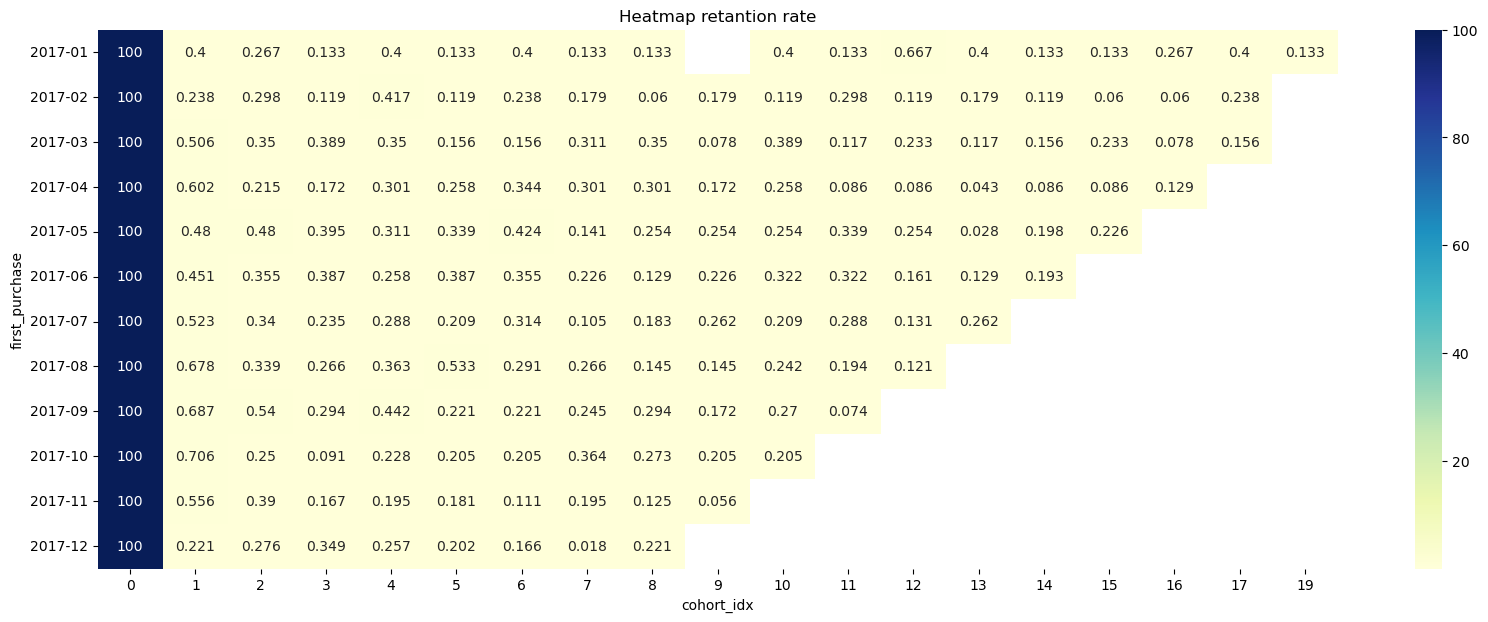

In [21]:
plt.figure(figsize=(20, 7))
plt.title('Heatmap retantion rate')
plt.xlabel('№ of Month')
plt.ylabel('cohort')
sns.heatmap(cohort_retention, annot=True, cmap='YlGnBu', fmt='g')



As you can see from the visualization, the retention rate for subsequent purchases is quite low in general. And is not as susceptible to change over time for all cohorts. The reason may be the specifics of the business itself. Perhaps we can get higher rates over longer time periods (a year or more). Perhaps our e-commerce business sells a solution that the user purchases once and for a long time. An example could be some small household appliance or something that the user does not need to update over time.

### 5. For quality audience analysis, It is often used approaches based on segmentation. Using Python, conduct RFM segmentation of users to qualitatively assess your audience. In the clustering, you may choose the following metrics: R - the time from the user's last purchase to the current date, F - the total number of purchases by the user over all time, M - the total sum of purchases over all time. Describe in detail how you created the clusters. For each RFM segment, define the boundaries of the recency, frequency, and monetary metrics for the interpretation of these clusters.

Since it's important in this case to satisfy the criteria of a purchase, we will only work with orders that meet our criteria. Recall that a purchase is defined as an order that has one of the following statuses: 'approved', 'invoiced', 'processing', 'shipped', 'delivered', and also has a confirmed payment time, i.e., "order_approved_at" is not empty.

In [22]:
# Let's create a df with completed purchases
approved_statuses = ['approved', 'invoiced', 'processing', 'shipped', 'delivered']
purchases = orders.query('order_status in @approved_statuses and order_approved_at.notna()')
purchases

,customer_unique_id,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10-01
1,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018-08-01
2,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018-09-01
3,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017-12-01
4,72632f0f9dd73dfee390c9b22eb56dd6,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018-02-01
...,...,...,...,...,...,...,...,...,...,...
99436,6359f309b166b0196dbf7ad2ac62bb5a,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,2017-03-01
99437,da62f9e57a76d978d02ab5362c509660,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,2018-03-01
99438,737520a9aad80b3fbbdad19b66b37b30,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,2017-09-01
99439,5097a5312c8b157bb7be58ae360ef43c,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,2018-02-01


In this task there will be two main dataframes: *rfm_data* and *rfm_table*, in the first we will prepare data for the basis of the table. The final segmentation will be in the rfm_table

The first step is to calculate the indicators for rfm classers.
First let's calculate recency. Let's find how many days have passed since the last order until the current date. Note that we will have 94973 unique users.

In [23]:
# df for working with segmentation
rfm_data = purchases[['customer_unique_id', 'order_id', 'order_purchase_timestamp']]
# Converting the 'order_purchase_timestamp' column to datetime data type
rfm_data.loc[:, 'order_purchase_timestamp'] = pd.to_datetime(rfm_data['order_purchase_timestamp'])

# Getting the current date
current_date = pd.to_datetime('today').normalize()

# Calculating the difference in days between the current date and the date of the last order to find recency
rfm_table = rfm_data.groupby('customer_unique_id', as_index=False)['order_purchase_timestamp'].max()
rfm_table['recency'] = (current_date - rfm_table['order_purchase_timestamp']).dt.days
rfm_table


,customer_unique_id,order_purchase_timestamp,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,2141
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,2144
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,2567
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,2351
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,2318
...,...,...,...
94968,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36,2477
94969,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,2292
94970,ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16,2598
94971,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:17:41,2149


Calculation of frequency, as you can see, users did not make purchases that often in general. And most of the users made a purchase only once, in view of this, it makes sense to calculate the frequency for the entire observation period, in which case this indicator for each user will be equal to the number of orders made by this user.

In [24]:
# frequency
freq = rfm_data.groupby('customer_unique_id', as_index=False).agg({'order_id' : 'count'}).rename(columns={'order_id' : 'frequency'})
rfm_table = rfm_table.merge(freq, on='customer_unique_id', how='left')
rfm_table

,customer_unique_id,order_purchase_timestamp,recency,frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,2141,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,2144,1
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,2567,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,2351,1
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,2318,1
...,...,...,...,...
94968,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36,2477,1
94969,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,2292,1
94970,ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16,2598,1
94971,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:17:41,2149,1


To calculate monetary, it's necessary to extract data from the df items, as that's where the price data is located. We'll calculate monetary in several steps:
* Calculate the total amount of each order in the items table. To do this, group by order_id and apply sum aggregation on the price.
* Merge the resulting df with our preparatory df rfm_data, using the order_id field, while applying a left join, meaning we'll take all values from the rfm_data table and attach corresponding values from the resulting order_price df. Since rfm_data already contains only those orders where a purchase has been made, we won't catch any extra price data.
* Group the resulting data by customer_unique_id and calculate the total price spent by the user in our store. Add the result to the resulting rfm table rfm_table.


In [25]:
# monetary

order_price = items.groupby('order_id', as_index=False).agg({'price' : 'sum'})
rfm_data = rfm_data.merge(order_price, on='order_id', how='left')
monet = rfm_data.groupby('customer_unique_id', as_index=False).agg({'price' : 'sum'}).rename(columns={'price' : 'monetary'})
rfm_table = rfm_table.merge(monet, on='customer_unique_id', how='left')
rfm_table

,customer_unique_id,order_purchase_timestamp,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,2141,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,2144,1,18.90
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,2567,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,2351,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,2318,1,180.00
...,...,...,...,...,...
94968,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36,2477,1,1570.00
94969,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,2292,1,64.89
94970,ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16,2598,1,89.90
94971,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:17:41,2149,1,115.00


In [26]:
rfm_table_2 = rfm_table[['recency', 'frequency', 'monetary']].apply(pd.to_numeric, errors='coerce')

We will define quantiles for each RFM parameter using 4 segments:
* less than 0.25
* from 0.25 to 0.5
* from 0.5 to 0.75
* more than 0.75

To translate our values into the RFM scale, we will create a function that takes a dataframe row as input, accesses either recency, frequency, or monetary, and assigns a value from the RFM scale to the corresponding variables. It assigns either 4, 3, 2, or 1 based on which percentile the value falls into. The function then returns a string value of the resulting parameters. By applying this function to the entire dataframe, we will have a column RFM_Segment in our table. This will be the result of our segmentation.

In [27]:
# Defining quantiles for each RFM parameter
quantiles = rfm_table_2.quantile(q=[0.25, 0.5, 0.75])

# Function for assigning segments
def rfm_segment(row):
    """
    Assigns an RFM segment to a customer based on recency, frequency, and monetary values.

    This function calculates scores for each RFM parameter by comparing the customer's RFM values 
    against the distribution of values in the dataset, divided into quartiles. 
    - Recency: Customers who have made a purchase more recently will receive a higher score.
    - Frequency: Customers who have made more purchases will receive a higher score.
    - Monetary: Customers who have spent more will receive a higher score.
    
    The function returns a string composed of the three scores in the order of Recency, Frequency, and Monetary (RFM).

    Parameters:
    - row (pd.Series): A row from a DataFrame that includes 'recency', 'frequency', and 'monetary' columns.

    Returns:
    - str: A string representing the RFM segment of the customer, composed of three characters where each character 
           is a digit (1-4) corresponding to the quartile in which the customer's value for each RFM parameter falls. 
           A higher number indicates a customer who is more recent, more frequent, and/or more monetary valuable.
    """
    if row['recency'] <= quantiles.loc[0.25, 'recency']:
        r_score = 4
    elif row['recency'] <= quantiles.loc[0.5, 'recency']:
        r_score = 3
    elif row['recency'] <= quantiles.loc[0.75, 'recency']:
        r_score = 2
    else:
        r_score = 1
    
    if row['frequency'] <= quantiles.loc[0.25, 'frequency']:
        f_score = 1
    elif row['frequency'] <= quantiles.loc[0.5, 'frequency']:
        f_score = 2
    elif row['frequency'] <= quantiles.loc[0.75, 'frequency']:
        f_score = 3
    else:
        f_score = 4
    
    if row['monetary'] <= quantiles.loc[0.25, 'monetary']:
        m_score = 1
    elif row['monetary'] <= quantiles.loc[0.5, 'monetary']:
        m_score = 2
    elif row['monetary'] <= quantiles.loc[0.75, 'monetary']:
        m_score = 3
    else:
        m_score = 4
    
    return str(r_score) + str(f_score) + str(m_score)

# Applying the function to the dataframe
rfm_table['RFM_Segment'] = rfm_table_2.apply(rfm_segment, axis=1)

# Outputting the result
rfm_table

,customer_unique_id,order_purchase_timestamp,recency,frequency,monetary,RFM_Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,2141,1,129.90,413
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,2144,1,18.90,411
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,2567,1,69.00,112
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,2351,1,25.99,211
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,2318,1,180.00,214
...,...,...,...,...,...,...
94968,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36,2477,1,1570.00,114
94969,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,2292,1,64.89,212
94970,ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16,2598,1,89.90,113
94971,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:17:41,2149,1,115.00,313


In [28]:
print(rfm_table.RFM_Segment.nunique())
print(rfm_table.RFM_Segment.unique())

32
['413' '411' '112' '211' '214' '313' '311' '314' '113' '111' '212' '312'
 '114' '412' '414' '213' '244' '442' '143' '344' '444' '144' '341' '142'
 '343' '243' '443' '242' '441' '342' '141' '241']


#### Answer:

We obtained 32 segments. Although there should have been more since there are 4 boundaries for each parameter and we have 3 parameters, so 4^3 = 64. However, due to the nature of the data, half of the segments simply do not exist, largely because most users made only one purchase and a long time ago.

To describe each segment and its boundaries, we will use loops, with the help of the describe method and filtering only by minimum and maximum values, to delineate all the segment boundaries.

**The description of each segment is below**

In [29]:
# Grouping data by the 'RFM_Segment' column
segment_groups = rfm_table.groupby('RFM_Segment')

# Creating a dictionary to store the metric boundaries of each segment
segment_boundaries = {}

# Iterating through each group and calculating metric boundaries
for segment, data in segment_groups:
    boundaries = data[['recency', 'frequency', 'monetary']].describe().loc[['min', 'max']]
    segment_boundaries[segment] = boundaries

# Displaying the metric boundaries for each RFM segment
for segment, boundaries in segment_boundaries.items():
    print(f"RFM segment {segment} (recency={segment[0]}, frequency={segment[1]}, monetary={segment[2]}) has metric boundaries:")
    print(f"Recency from {boundaries.loc['min', 'recency']} to {boundaries.loc['max', 'recency']} days")
    print(f"Frequency from {boundaries.loc['min', 'frequency']} to {boundaries.loc['max', 'frequency']} orders")
    print(f"Monetary from {boundaries.loc['min', 'monetary']} to {boundaries.loc['max', 'monetary']} rubles")
    print()


RFM segment 111 (recency=1, frequency=1, monetary=1) has metric boundaries:
Recency from 2378.0 to 2725.0 days
Frequency from 1.0 to 1.0 orders
Monetary from 0.0 to 47.9 rubles

RFM segment 112 (recency=1, frequency=1, monetary=2) has metric boundaries:
Recency from 2378.0 to 2754.0 days
Frequency from 1.0 to 1.0 orders
Monetary from 47.98 to 89.81 rubles

RFM segment 113 (recency=1, frequency=1, monetary=3) has metric boundaries:
Recency from 2378.0 to 2743.0 days
Frequency from 1.0 to 1.0 orders
Monetary from 89.9 to 155.0 rubles

RFM segment 114 (recency=1, frequency=1, monetary=4) has metric boundaries:
Recency from 2378.0 to 2724.0 days
Frequency from 1.0 to 1.0 orders
Monetary from 155.39999999999998 to 6735.0 rubles

RFM segment 141 (recency=1, frequency=4, monetary=1) has metric boundaries:
Recency from 2392.0 to 2631.0 days
Frequency from 2.0 to 4.0 orders
Monetary from 20.7 to 46.77 rubles

RFM segment 142 (recency=1, frequency=4, monetary=2) has metric boundaries:
Recency fr

Text(0, 0.5, 'Amount of users per segment')

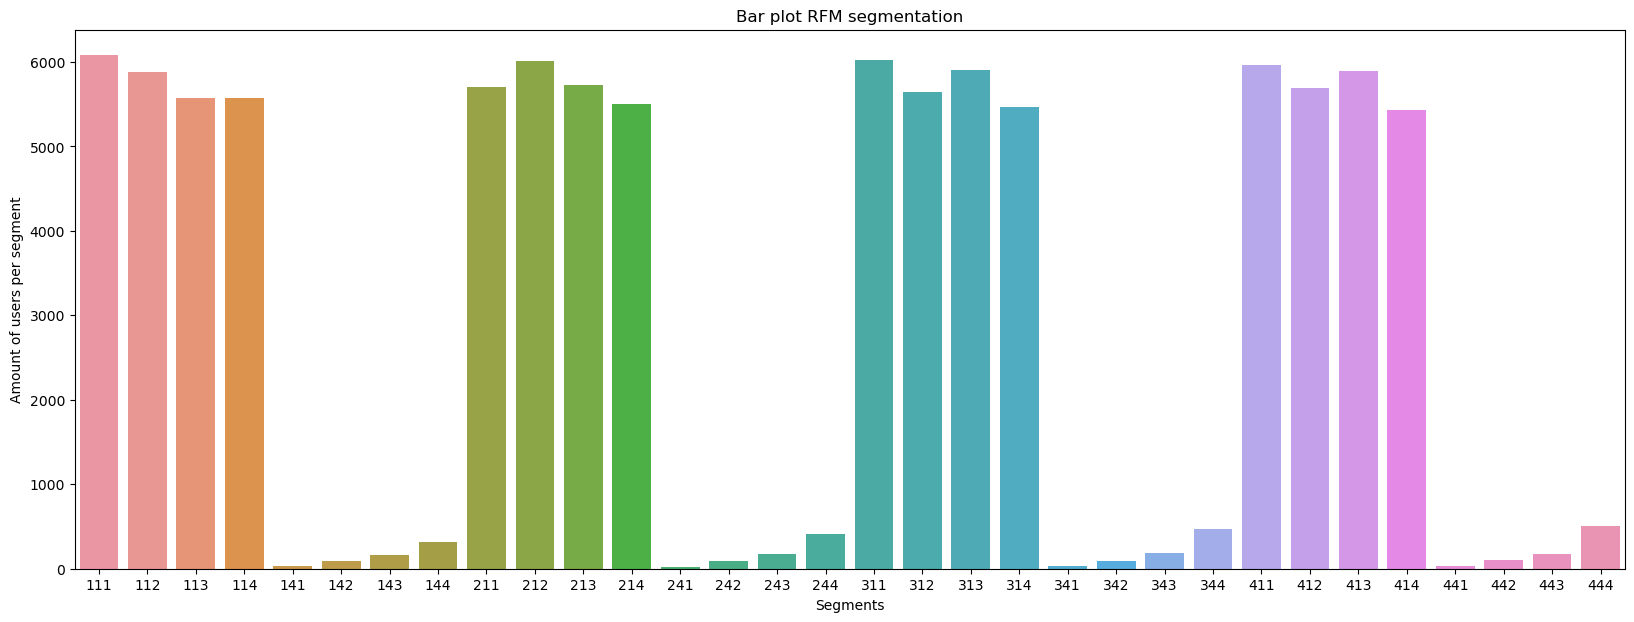

In [30]:
# Visualization of segments by the number of users in each segment

rfm_vis = rfm_table.groupby('RFM_Segment', as_index=False).agg({'customer_unique_id' : 'count'})
plt.figure(figsize=(20, 7))
plt.title('Bar plot RFM segmentation')
sns.barplot(data=rfm_vis , x='RFM_Segment', y='customer_unique_id')
plt.xlabel('Segments')
plt.ylabel('Amount of users per segment')